In [1]:
# # From tensorflow/models/
# protoc object_detection/protos/*.proto --python_out=.

In [11]:
%matplotlib inline

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import sys
sys.path.append('./tensorflow-models/')
sys.path.append('./tensorflow-models/object_detection')

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from tqdm import tqdm

In [3]:
MODEL_NAME = 'faster_rcnn_resnet101_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
NUM_CLASSES = 90

In [4]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#     file_name = os.path.basename(file.name)
#     if 'frozen_inference_graph.pb' in file_name:
#         tar_file.extract(file, os.getcwd())

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
train_data = np.load('d2/image_train.npz')
x_train = train_data['xs']

val_data = np.load('d2/image_val.npz')
x_val = val_data['xs']

In [17]:
y_train = train_data['ys']
y_val = val_data['ys']

In [34]:
def extract_human(xs):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for x in tqdm(xs):
            x = x.astype(np.uint8)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: np.expand_dims(x, axis=0)})
            
            person_indices = classes == 1 # person
            score_indices = scores > 0.60
            indices = person_indices & score_indices
            boxes = boxes[indices]
            scores = scores[indices]
            classes = classes[indices]
            num = indices.sum()
            
            yield num, boxes, scores
            
#             vis_util.draw_bounding_boxes_on_image_array(
#                 x, 
#                 np.squeeze(boxes), 
#                 display_str_list_list=[[f'{x:.2f}'] for x in np.squeeze(scores)], 
#                 thickness=2)
#             plt.figure(figsize=(20, 15))
#             plt.imshow(x)
            

In [19]:
hls = list([x_train[i] for i in range(100) if y_train[i] == 1])
nums = list(extract_human(hls))
print(nums)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:01<00:00,  1.30s/it]


[6, 8, 1, 4, 1, 2, 4, 2, 2, 5, 2, 3, 2, 2, 2, 4, 2, 4, 5, 2, 3, 4, 3, 3, 0, 4, 4, 1, 3, 2, 3, 3, 2, 5, 1, 3, 5, 2, 2, 1, 4, 2]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003C20B240>]], dtype=object)

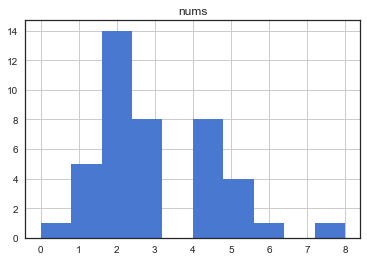

In [29]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
sns.set(style='white', palette='muted')

df = pd.DataFrame(nums, columns=['nums'])
df.hist()

In [50]:
N = 500
df = pd.DataFrame(index=range(N), columns=['num', 'boxes', 'scores'])
for i, (num, boxes, scores) in enumerate(extract_human(x_train[:N])):
    df['num'][i] = num
    df['boxes'][i] = boxes
    df['scores'][i] = scores
print((df['num'] < 2).sum())

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [11:03<00:00,  1.31s/it]


63


4
